In [2]:
import sys, os
import matplotlib as mpl
import matplotlib.pyplot as plt
import pickle as pkl
import seaborn as sns
import numpy as np
import pandas as pd
from tqdm import tqdm
import torch
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from functools import reduce
from matplotlib.ticker import MaxNLocator

from src.models.XCRISP.deletion import load_data, load_model, NeuralNetwork, FEATURE_SETS, _to_tensor
from src.data.data_loader import get_details_from_fasta


def rename_columns(df):
    df = df.rename(columns={
        "leftEdge": "Left Edge",
        "rightEdge": "Right Edge",
        "homologyLength": "MH Length",
        "homologyGCContent": "MH GC",
    })
    return df

exp = "v4"
dataset = "test"
loss = "Base"
num_reads = 100
random_state = 1
TSV_FILE_All = "/Users/colm/repos/output/local/model_shap_values/model_kld_{}.{}.shap.tsv"

X, y, _ = load_data(dataset = dataset)
X = rename_columns(X)
guides = get_details_from_fasta("/Users/colm/repos/repair-outcome-prediction/local/data/FORECasT/{}.fasta".format(dataset))
features = ["Gap", "Left Edge", "Right Edge", "MH Length", "MH GC%"]

shap_values_all = pd.read_csv(TSV_FILE_All.format(dataset, "all"), sep="\t").set_index(["Sample_Name", "Indel"])
shap_values_all = rename_columns(shap_values_all)
quantiles = shap_values_all.quantile(.99)
outlying_shap_values = shap_values_all.apply(lambda x: x.ge(quantiles) , axis=1)
# a = shap_values_all[~outlying_shap_values.any(axis=1)]
a = shap_values_all.stack().reset_index().rename(columns={"level_2": "Feature", 0: "SHAP Value"}).set_index(["Sample_Name", "Indel", "Feature"])
b = X.loc[X["MH Length"] > 0, shap_values_all.columns]
b = b.sample(5000, random_state=1)
b = b.stack().reset_index().rename(columns={"level_2": "Feature", 0: "Feature Value"}).set_index(["Sample_Name", "Indel", "Feature"])
b["Del Type"] = "MH-Based"

c = X.loc[X["MH Length"] == 0, shap_values_all.columns]
c = c.sample(5000, random_state=1)
c = c.stack().reset_index().rename(columns={"level_2": "Feature", 0: "Feature Value"}).set_index(["Sample_Name", "Indel", "Feature"])
c["Del Type"] = "MH-Less"

2025-02-28 16:54:43.596455: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Users/colm/anaconda3/envs/xcrisp/lib/python3.9/site-packages/pandas/core/ops/common.py:123: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if a.name == b.name:


In [3]:
# b = (b-b.min())/(b.max()-b.min())
swarm_df = a.join(b, on=["Sample_Name", "Indel", "Feature"], how="inner").reset_index()
swarm_df2 = a.join(c, on=["Sample_Name", "Indel", "Feature"], how="inner").reset_index()
swarm_df = pd.concat([swarm_df, swarm_df2])
# print(swarm_df.head())

for feature in swarm_df["Feature"].unique():
    feature_idx = swarm_df["Feature"] == feature
    fv = swarm_df["Feature Value"][feature_idx]
    swarm_df["Feature Value"][feature_idx] = (fv-fv.min())/(fv.max()-fv.min())

swarm_df.head()

/var/folders/5x/n2td64g918lgvdh3qm2x3bhc0000gn/T/ipykernel_68427/340343850.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  swarm_df["Feature Value"][feature_idx] = (fv-fv.min())/(fv.max()-fv.min())
/var/folders/5x/n2td64g918lgvdh3qm2x3bhc0000gn/T/ipykernel_68427/340343850.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  swarm_df["Feature Value"][feature_idx] = (fv-fv.min())/(fv.max()-fv.min())
/var/folders/5x/n2td64g918lgvdh3qm2x3bhc0000gn/T/ipykernel_68427/340343850.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

,Sample_Name,Indel,Feature,SHAP Value,Feature Value,Del Type
0,Oligo_10007,-7+26,Gap,5.383666e-06,0.733333,MH-Based
1,Oligo_10007,-7+26,Left Edge,5.110184e-07,0.766667,MH-Based
2,Oligo_10007,-7+26,Right Edge,-6.942527e-06,0.533333,MH-Based
3,Oligo_10007,-7+26,MH Length,2.244979e-06,0.333333,MH-Based
4,Oligo_10007,-7+26,MH GC,3.387809e-07,1.000000,MH-Based


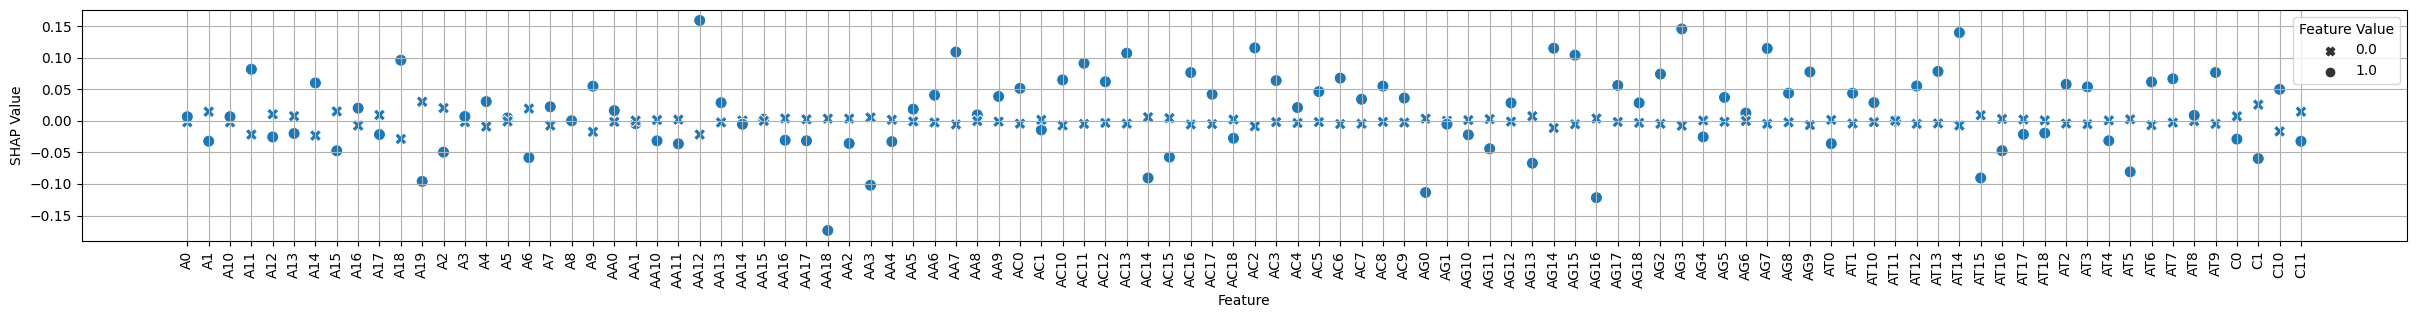

In [5]:
TSV_FILE_INDEL = "/Users/colm/repos/output/local/model_shap_values/indel_test.shap.pkl"
dataset = "test"
guides = get_details_from_fasta("/Users/colm/repos/repair-outcome-prediction/local/data/FORECasT/{}.fasta".format(dataset))
features = ["Gap", "Left Edge", "Right Edge", "MH Length", "MH GC%"]
shap_values_all = pkl.load(open(TSV_FILE_INDEL, "rb"))
background_samples = shap_values_all[1]
columns = shap_values_all[2]
data = pkl.load(open(os.environ["OUTPUT_DIR"] + "model_training/data_100x/Lindel/Tijsterman_Analyser/test", 'rb'))
feature_idx = 2
background = []
for b in background_samples:
    background.append(data[b][feature_idx])
    
background = pd.DataFrame(background, columns=columns, index=background_samples)
background = background.melt(var_name="Feature", value_name="Feature Value", ignore_index=False).reset_index().set_index(["index", "Feature"])

shap_indel_df = pd.DataFrame(shap_values_all[0][0,:,:], index=shap_values_all[1], columns=shap_values_all[2])
indel_order = shap_indel_df.abs().mean().sort_values(ascending=False)[:30].index.to_list()
indel_swarm_df = shap_indel_df.melt(var_name="Feature", value_name="SHAP Value", ignore_index=False)
indel_swarm_df = indel_swarm_df.reset_index().set_index(["index", "Feature"])
indel_swarm_df = indel_swarm_df.join(background).reset_index().set_index(["index"]).drop_duplicates()

sorted_indel_features = np.array([])

for i in range(1, 10):
    single_indel_features = np.array([f for f in indel_order if (len(f) == 2) and f[-1:] == str(i)])
    single_indel_features = single_indel_features[np.argsort([single_indel_features])]
    sorted_indel_features = np.append(sorted_indel_features, single_indel_features)

for i in range(10, 20):
    single_indel_features = np.array([f for f in indel_order if (len(f) == 3) and f[-2:] == str(i)])
    single_indel_features = single_indel_features[np.argsort([single_indel_features])]
    sorted_indel_features = np.append(sorted_indel_features, single_indel_features)

for i in range(1, 10):
    di_indel_features = np.array([f for f in indel_order if (len(f) == 3) and f[-1:] == str(i) and f[-2] in "ACTG"])
    di_indel_features = di_indel_features[np.argsort([di_indel_features])]
    sorted_indel_features = np.append(sorted_indel_features, di_indel_features)

for i in range(10, 20):
    di_indel_features = np.array([f for f in indel_order if (len(f) == 4) and f[-2:] == str(i)])
    di_indel_features = di_indel_features[np.argsort([di_indel_features])]
    sorted_indel_features = np.append(sorted_indel_features, di_indel_features)

# indel_swarm_df = indel_swarm_df[indel_swarm_df["Feature"].isin(sorted_indel_features)]
# indel_swarm_df["Feature"] = pd.Categorical(indel_swarm_df["Feature"], categories=sorted_indel_features, ordered=True)
plt.subplots(1, 1, figsize=(30, 3))

sns.scatterplot(data=indel_swarm_df.sort_values(by=["Feature"], ascending=True).head(200),\
     x="Feature", y="SHAP Value", style="Feature Value", palette="viridis",  markers=["X", "o"], s=75)
plt.xticks(rotation=90)
plt.grid('on')
plt.show()

<Axes: xlabel='SHAP Value', ylabel='Feature'>

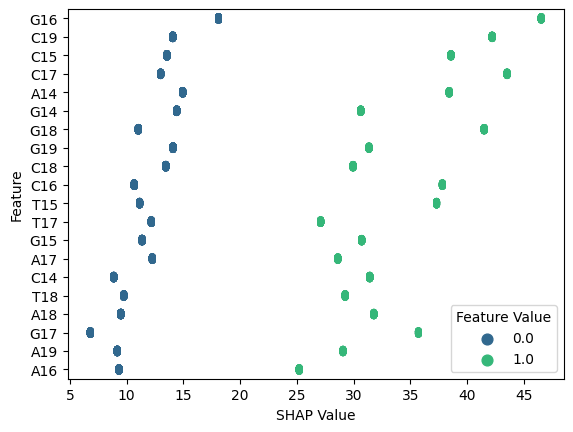

In [6]:
TSV_FILE_INSERTION = "/Users/colm/repos/output/local/model_shap_values/insertion_test.shap.pkl"
dataset = "test"
guides = get_details_from_fasta("/Users/colm/repos/repair-outcome-prediction/local/data/FORECasT/{}.fasta".format(dataset))
features = ["Gap", "Left Edge", "Right Edge", "MH Length", "MH GC%"]
shap_values_all = pkl.load(open(TSV_FILE_INSERTION, "rb"))
background_samples = shap_values_all[1]
columns = shap_values_all[2]
data = pkl.load(open(os.environ["OUTPUT_DIR"] + "model_training/data_100x/Lindel/Tijsterman_Analyser/test", 'rb'))
feature_idx = 3
background = []
for b in background_samples:
    background.append(data[b][feature_idx])
    
background = pd.DataFrame(background, columns=columns, index=background_samples)
background = background.melt(var_name="Feature", value_name="Feature Value", ignore_index=False).reset_index().set_index(["index", "Feature"])

shap_insertion_df = pd.DataFrame(np.absolute(shap_values_all[0]).sum(axis=0), index=shap_values_all[1], columns=shap_values_all[2])
insertion_order = shap_insertion_df.abs().mean().sort_values(ascending=False)[:20].index.to_list()
insertion_swarm_df = shap_insertion_df.melt(var_name="Feature", value_name="SHAP Value", ignore_index=False)
insertion_swarm_df = insertion_swarm_df.reset_index().set_index(["index", "Feature"])

insertion_swarm_df = insertion_swarm_df.join(background).reset_index()
insertion_swarm_df.head()

sns.stripplot(data=insertion_swarm_df[insertion_swarm_df.Feature.isin(insertion_order)],\
     y="Feature", x="SHAP Value", order=insertion_order, hue="Feature Value", palette="viridis")

<Axes: >

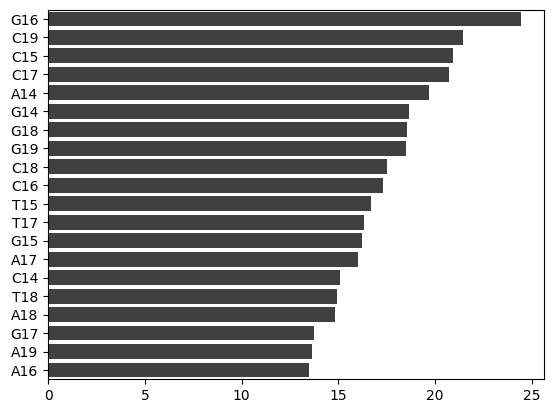

In [7]:
mean_ins_shap_values = shap_insertion_df.mean(axis=0)
order1 = mean_ins_shap_values.sort_values(ascending=False)[:20].index.to_list()
sns.barplot(x=mean_ins_shap_values.loc[order1], y=order1, color=".25")

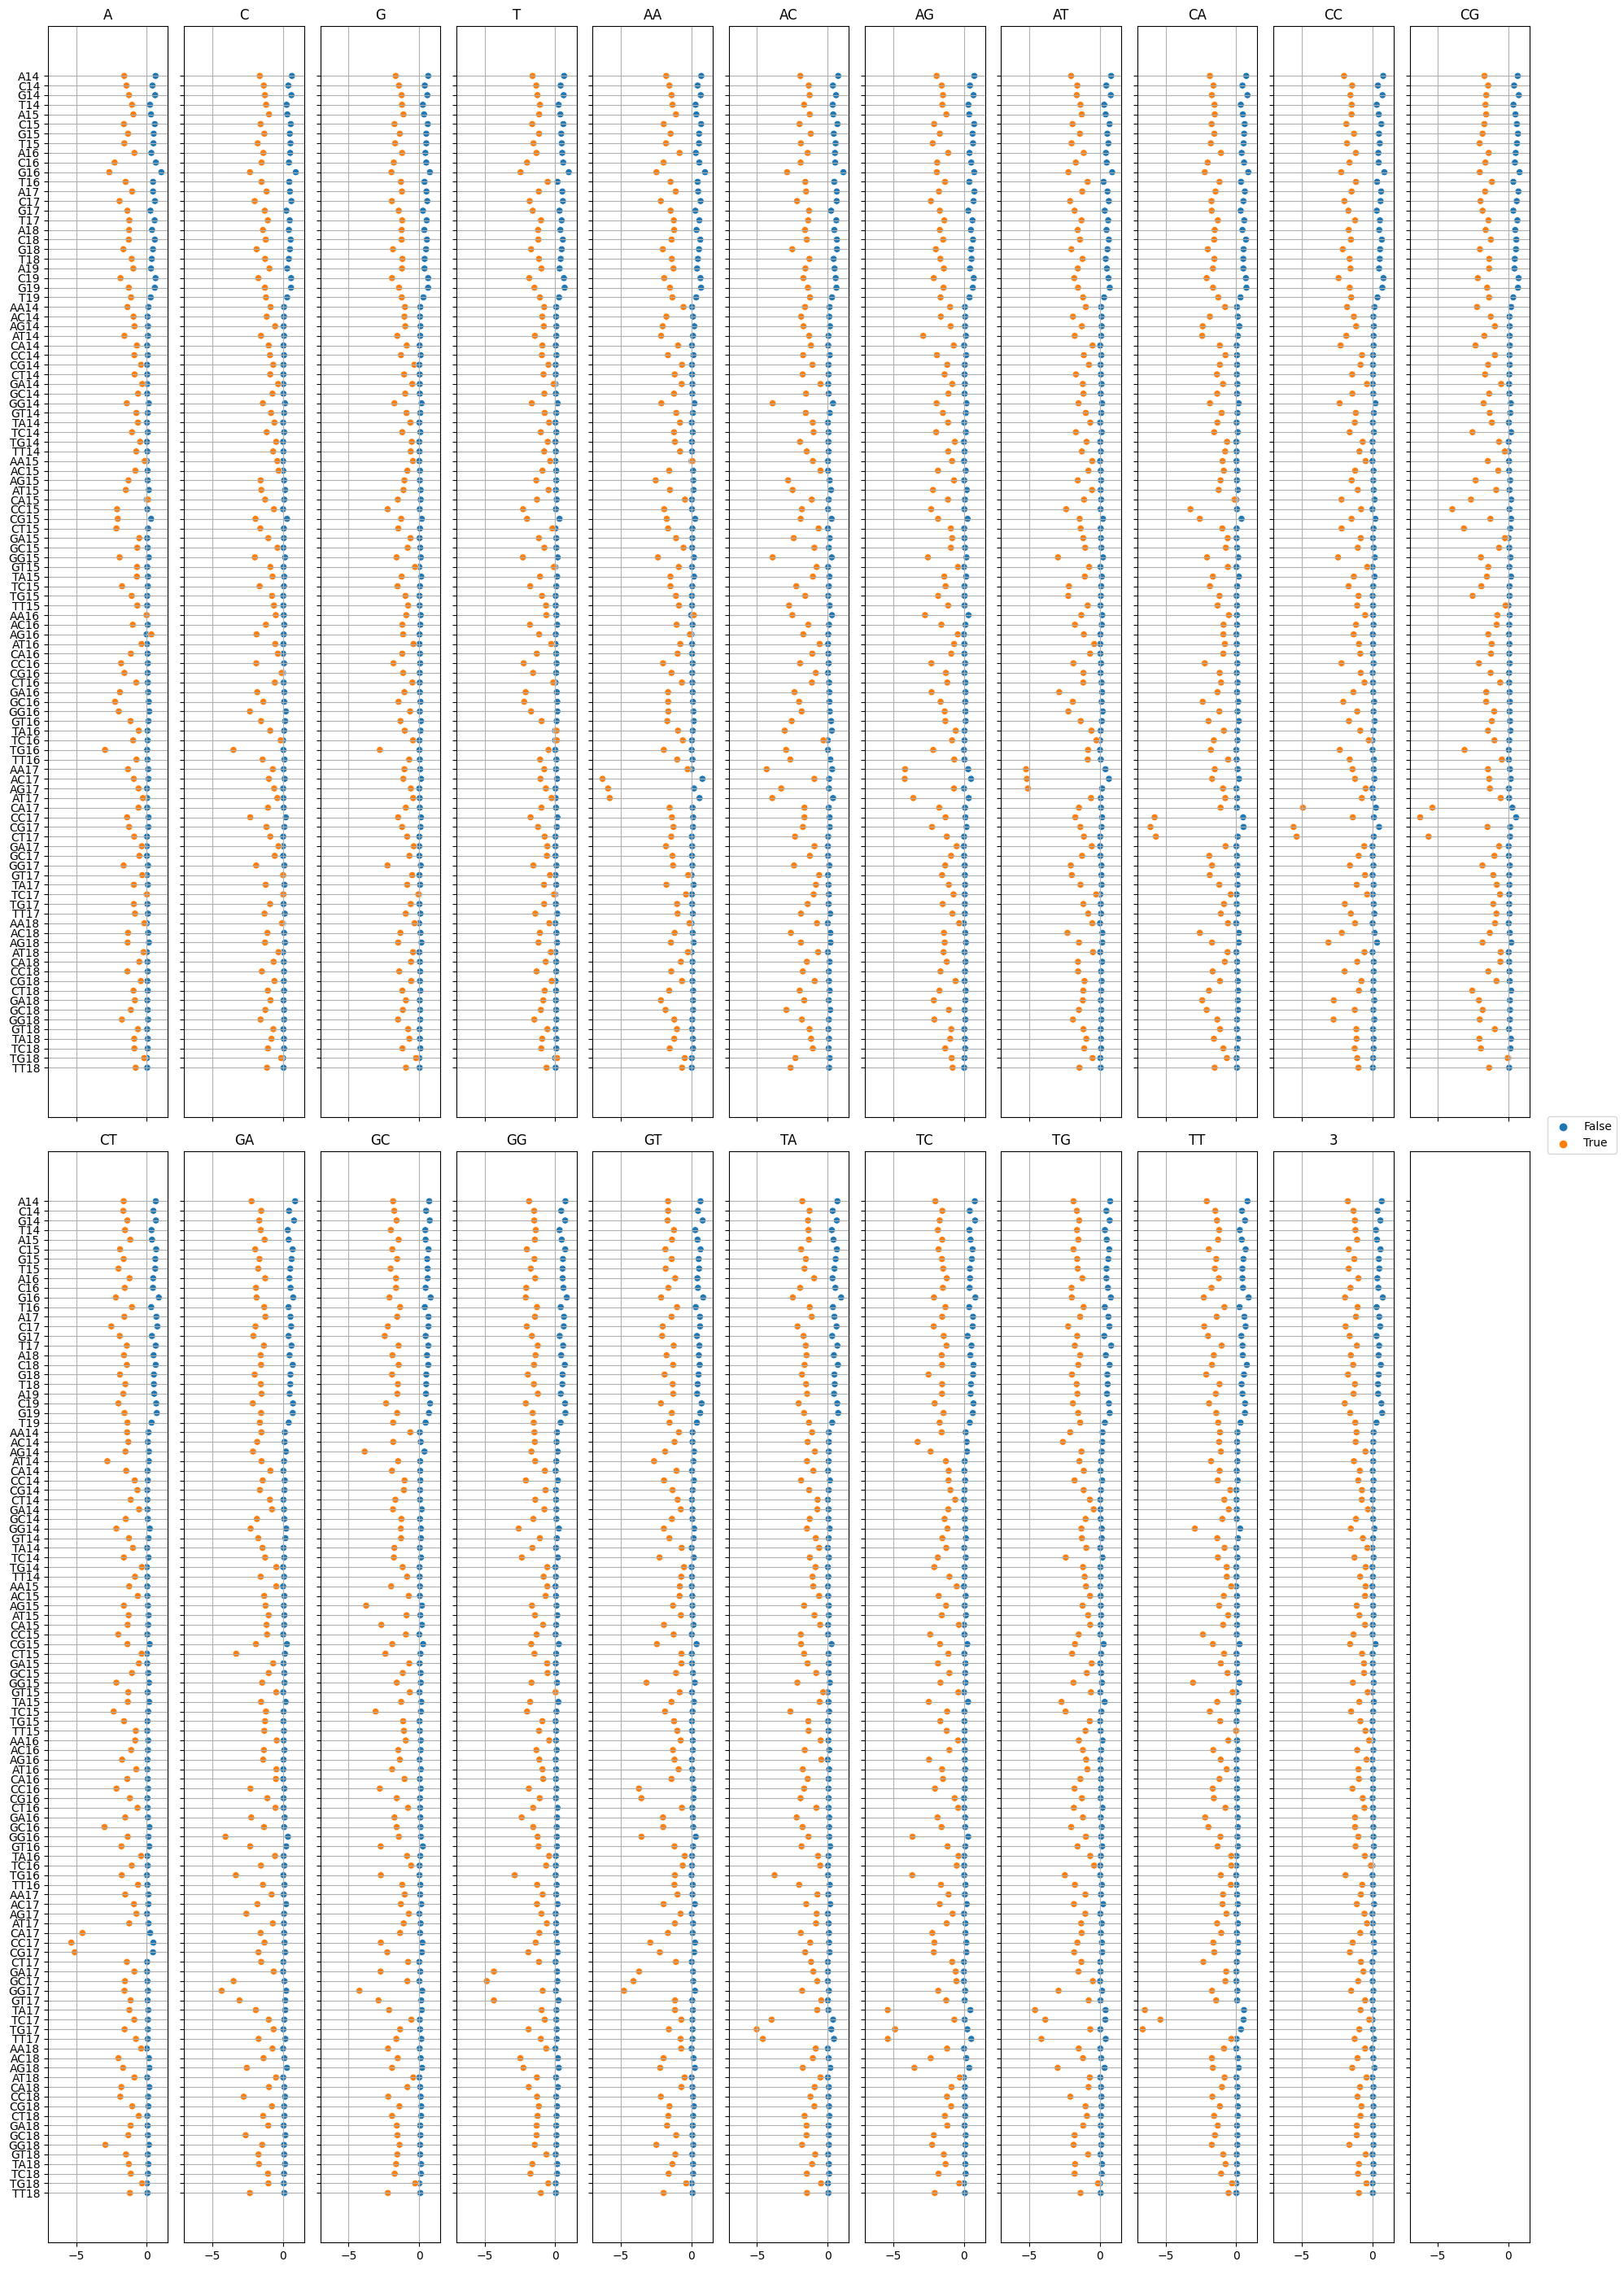

In [8]:
def generate_1_and_2_bp_insertions():
    nucs = ["A", "C", "G", "T"]
    onebps = []
    twobps = []
    for n1 in nucs:
        onebps.append( n1)
        for n2 in nucs:
            twobps.append(n1 + n2)
    return onebps + twobps

common_insertions = generate_1_and_2_bp_insertions()

def plot_for_insertion(ins, title, ax):
    index = shap_values_all[1]
    columns = shap_values_all[2]
    insertions = shap_values_all[3]
    idx = insertions.index(ins)
    shap_1A_df = pd.DataFrame(shap_values_all[0][idx,:,:], index=shap_values_all[1], columns=shap_values_all[2])
    A_swarm_df = shap_1A_df.melt(var_name="Feature", value_name="SHAP Value", ignore_index=False)
    A_swarm_df = A_swarm_df.reset_index().set_index(["index", "Feature"])
    A_swarm_df = A_swarm_df.join(background).reset_index().set_index("index")
    A_swarm_df = A_swarm_df.drop_duplicates()
    # A_order = shap_1A_df.abs().mean().sort_values(ascending=False)[:40].index.to_list()

    sorted_features = np.array([])

    for i in range(14, 20):
        single_features = np.array([n + str(i) for n in common_insertions if len(n) == 1])
        sorted_features = np.append(sorted_features, single_features)

    for i in range(14, 19):
        di_features = np.array([n + str(i) for n in common_insertions if len(n) == 2])
        sorted_features = np.append(sorted_features, di_features)

    A_swarm_df["Feature"] = pd.Categorical(A_swarm_df["Feature"], categories=sorted_features, ordered=True)

    
    g = sns.scatterplot(data=A_swarm_df.drop_duplicates(), x="SHAP Value", y="Feature", hue="Feature Value", ax=ax)
    return g



fig, axs = plt.subplots(2, 11, figsize=(19, 28), sharex=True, sharey=True)
for i, nucs in enumerate(common_insertions + ["3"]):
    axsi = axs[0 if i < 11 else 1, i if i < 11 else i - 11]

    if nucs == "3":
        g = plot_for_insertion(nucs, nucs, axsi)
    else:
        ins = "{}+{}".format(len(nucs), nucs)
        g = plot_for_insertion(ins, nucs, axsi)
    handles, labels = axsi.get_legend_handles_labels()
    g.legend().remove()
    axsi.title.set_text(nucs)
    axsi.grid()
    axsi.set(xlabel='', ylabel='')

plt.tight_layout()
fig.legend(handles, ["False", "True"], loc='center left', bbox_to_anchor=(1, 0.5))


In [9]:
# def plot_1bp_insertion(ins):
TSV_FILE_INSERTION = "/Users/colm/repos/output/local/model_shap_values/insertion_test.shap.pkl"
dataset = "test"
guides = get_details_from_fasta("/Users/colm/repos/repair-outcome-prediction/local/data/FORECasT/{}.fasta".format(dataset))
features = ["Gap", "Left Edge", "Right Edge", "MH Length", "MH GC%"]
shap_values_all = pkl.load(open(TSV_FILE_INSERTION, "rb"))
background_samples = shap_values_all[1]
columns = shap_values_all[2]
data = pkl.load(open(os.environ["OUTPUT_DIR"] + "model_training/data_100x/Lindel/Tijsterman_Analyser/test", 'rb'))
feature_idx = 3
background = []
for b in background_samples:
    background.append(data[b][feature_idx])
background = pd.DataFrame(background, columns=columns, index=background_samples)
background = background.melt(var_name="Feature", value_name="Feature Value", ignore_index=False).reset_index().set_index(["index", "Feature"])
index = shap_values_all[1]
columns = shap_values_all[2]
insertions = shap_values_all[3]
ins_classes = ["1+A", "1+T", "1+C", "1+G"]
all_features = []
for ins in ins_classes:
    idx = insertions.index(ins)
    shap_1A_df = pd.DataFrame(shap_values_all[0][idx,:,:], index=shap_values_all[1], columns=shap_values_all[2])
    A_swarm_df = shap_1A_df.melt(var_name="Feature", value_name="SHAP Value", ignore_index=False)
    A_swarm_df = A_swarm_df.reset_index().set_index(["index", "Feature"])
    A_swarm_df = A_swarm_df.join(background).reset_index().set_index("index")
    A_swarm_df = A_swarm_df.reset_index(drop=True).drop_duplicates()

    # choosing what features get displayed

    bottom5pos = A_swarm_df[A_swarm_df["Feature Value"] == 1].sort_values(by=["SHAP Value"]).head()["Feature"]
    top5pos = A_swarm_df[A_swarm_df["Feature Value"] == 1].sort_values(by=["SHAP Value"], ascending=False).head()["Feature"]
    bottom5neg = A_swarm_df[A_swarm_df["Feature Value"] == 0].sort_values(by=["SHAP Value"]).head()["Feature"]
    top5neg = A_swarm_df[A_swarm_df["Feature Value"] == 0].sort_values(by=["SHAP Value"], ascending=False).head()["Feature"]
    all_features = reduce(np.union1d, (all_features, bottom5pos, top5pos, bottom5neg, top5neg))

sorted_features = np.array([])

for i in range(13, 19):
    single_features = np.array([f for f in all_features if (len(f) == 3) and f[-2:] == str(i)])
    single_features = single_features[np.argsort([single_features])]
    sorted_features = np.append(sorted_features, single_features)

for i in range(13, 19):
    di_features = np.array([f for f in all_features if (len(f) == 4) and f[-2:] == str(i)])
    di_features = di_features[np.argsort([di_features])]
    sorted_features = np.append(sorted_features, di_features)
sorted_features

dfs = []
for ins in ins_classes:
    idx = insertions.index(ins)
    shap_1A_df = pd.DataFrame(shap_values_all[0][idx,:,:], index=shap_values_all[1], columns=shap_values_all[2])
    A_swarm_df = shap_1A_df.melt(var_name="Feature", value_name="SHAP Value", ignore_index=False)
    A_swarm_df = A_swarm_df.reset_index().set_index(["index", "Feature"])
    A_swarm_df = A_swarm_df.join(background).reset_index().set_index("index")
    A_swarm_df = A_swarm_df.reset_index(drop=True).drop_duplicates()
    A_swarm_df["Class"] = ins
    dfs.append(A_swarm_df)
    
ins_swarm_df = pd.concat(dfs)
# ins_swarm_df = ins_swarm_df[ins_swarm_df.Feature.isin(all_features)]
ins_swarm_df = ins_swarm_df.drop_duplicates()
# ins_swarm_df["Feature"] = pd.Categorical(ins_swarm_df["Feature"], categories=sorted_features, ordered=True)

In [10]:
all_features

array(['A14', 'AA15', 'AA16', 'AA18', 'AG16', 'C15', 'C16', 'C17', 'C19',
       'CA15', 'CC15', 'CC16', 'CC17', 'CG14', 'CG16', 'CT15', 'G14',
       'G16', 'G19', 'GA17', 'GC16', 'GG15', 'GG16', 'GG17', 'GT15',
       'GT17', 'TA16', 'TC16', 'TC17', 'TG16', 'TG18'], dtype=object)

In [11]:
swarm_df[swarm_df["Sample_Name"] != "Oligo_14023"]

,Sample_Name,Indel,Feature,SHAP Value,Feature Value,Del Type
0,Oligo_10007,-7+26,Gap,5.383666e-06,0.733333,MH-Based
1,Oligo_10007,-7+26,Left Edge,5.110184e-07,0.766667,MH-Based
2,Oligo_10007,-7+26,Right Edge,-6.942527e-06,0.533333,MH-Based
3,Oligo_10007,-7+26,MH Length,2.244979e-06,0.333333,MH-Based
4,Oligo_10007,-7+26,MH GC,3.387809e-07,1.000000,MH-Based
...,...,...,...,...,...,...
2585,Oligo_14255,-3+28,Gap,1.843319e-06,0.933333,MH-Less
2586,Oligo_14255,-3+28,Left Edge,1.542273e-07,0.900000,MH-Less
2587,Oligo_14255,-3+28,Right Edge,-2.319443e-06,0.866667,MH-Less
2588,Oligo_14255,-3+28,MH Length,-2.415665e-07,0.000000,MH-Less


/var/folders/5x/n2td64g918lgvdh3qm2x3bhc0000gn/T/ipykernel_68427/3082228274.py:34: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for lh in leg1.legendHandles:
/var/folders/5x/n2td64g918lgvdh3qm2x3bhc0000gn/T/ipykernel_68427/3082228274.py:55: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for lh in leg2.legendHandles:
/var/folders/5x/n2td64g918lgvdh3qm2x3bhc0000gn/T/ipykernel_68427/3082228274.py:95: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax3.set_xticklabels(sorted_features, rotation=90)
/var/folders/5x/n2td64g918lgvdh3qm2x3bhc0000gn/T/ipykernel_68427/3082228274.py:104: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after se

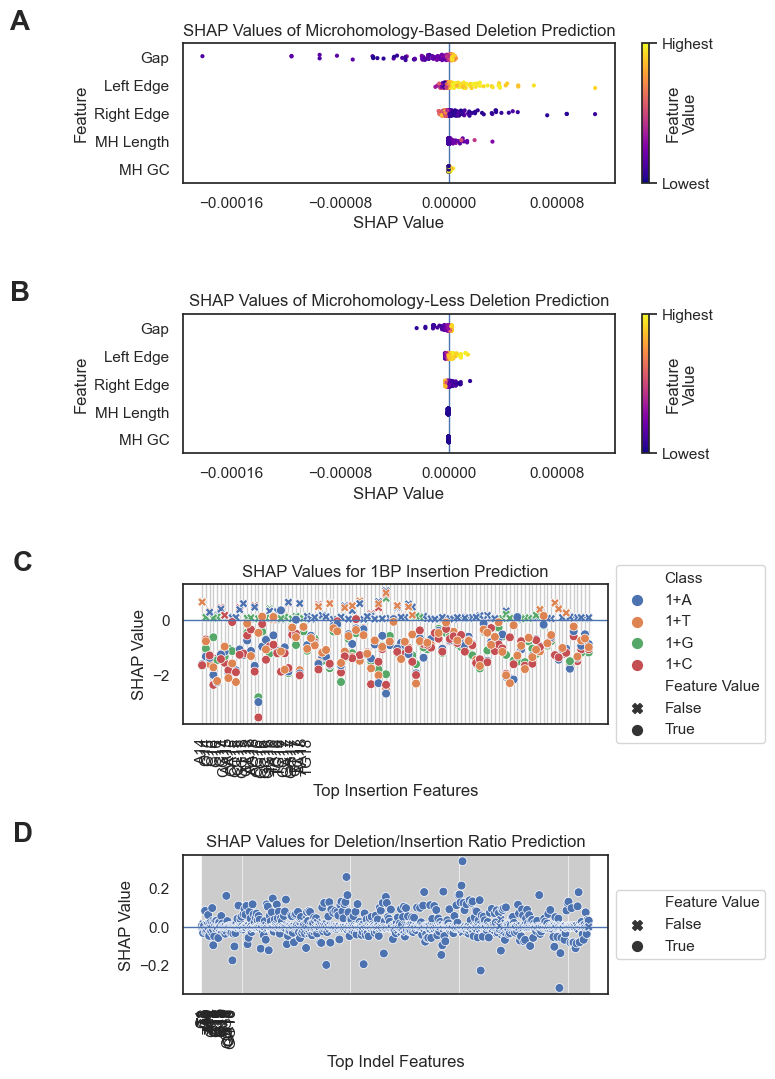

In [12]:
import string

samples_to_drop = ["Oligo_14023"]

swarm_df = swarm_df[swarm_df["Sample_Name"] != "Oligo_14023"]


abs_median_df = swarm_df.iloc[:,2:4]
abs_median_df["SHAP Value"] = abs_median_df["SHAP Value"].abs()
abs_median_df = abs_median_df.groupby("Feature").median().reset_index()
feature_order = list(abs_median_df.sort_values("SHAP Value", ascending=False)["Feature"])

sns.set(font_scale=1)
sns.set_style("white")

fig = plt.figure(figsize=(8, 11))

swarm_df["log10(abs(SHAP Value))"] = np.log10(np.abs(swarm_df["SHAP Value"]))
swarm_df["log10(abs(SHAP Value))"] = swarm_df["log10(abs(SHAP Value))"] * np.where(swarm_df["SHAP Value"] > 0, -1, 1)

SV_to_plot = "SHAP Value"
# SV_to_plot = "log10(abs(SHAP Value))"
ax1 = fig.add_subplot(411)
g = sns.stripplot(data=swarm_df[swarm_df["Del Type"] == "MH-Based"], \
    x=SV_to_plot , y="Feature", hue="Feature Value", \
        palette='plasma', s=3, order=feature_order, \
            ax=ax1)
g.legend().remove()

ax3 = fig.add_subplot(413)
g = sns.scatterplot(data=ins_swarm_df.sort_values(by=["Feature Value"], ascending=True), \
    y="SHAP Value", x="Feature", hue="Class", style="Feature Value", s=40, palette="deep", markers=["X", "o"], ax=ax3)
leg1 = g.legend(loc='center left', bbox_to_anchor=(1, 0.5))
for lh in leg1.legendHandles: 
    lh.set_alpha(1)
    lh._sizes = [50] 
plt.grid(axis="x")
leg1.get_texts()[-2].set_text('False')
leg1.get_texts()[-1].set_text('True')


ax2 = fig.add_subplot(412)

g = sns.stripplot(data=swarm_df[swarm_df["Del Type"] == "MH-Less"], \
    x=SV_to_plot, y="Feature", hue="Feature Value", \
        palette='plasma', s=3, order=feature_order, \
            ax=ax2)
g.legend().remove()

ax4 = fig.add_subplot(414)
ax4.plot([], [], ' ', label="Feature Value")
g = sns.scatterplot(data=indel_swarm_df.sort_values(by=["Feature"], ascending=True),\
     x="Feature", y="SHAP Value", style="Feature Value", palette='plasma', ax=ax4, markers=["X", "o"], s=40)
leg2 = g.legend(loc='center left', bbox_to_anchor=(1, 0.5))
for lh in leg2.legendHandles: 
    lh.set_alpha(1)
    lh._sizes = [50] 
plt.grid(axis="x")
leg2.get_texts()[-2].set_text('False')
leg2.get_texts()[-1].set_text('True')

norm = plt.Normalize(0, 1)
sm = plt.cm.ScalarMappable(cmap='plasma', norm=norm)
sm.set_array([])

SV_xlabel = r'$log_{10}(|SV|)$ ' + r'$\times$' + ' $sign(SV)^{-1}$' if "log10" in SV_to_plot else "SHAP Value"
SV_xlim =  (-10, 10) if "log10" in SV_to_plot else (-2.5e-4, 2.5e-4)


ax1.axvline(0.0, linewidth=1)
ax1.title.set_text('SHAP Values of Microhomology-Based Deletion Prediction')
ax1.set_ylabel("Feature")
ax1.set_xlabel(SV_xlabel)
ax1.xaxis.set_major_locator(MaxNLocator(5)) 
cbar = fig.colorbar(sm, ax=ax1)
cbar.set_ticks([0.0, 1.0])
cbar.set_ticklabels(["Lowest", "Highest"])
cbar.ax.set_ylabel('Feature\nValue', labelpad=-35, rotation=90)


ax2.axvline(0.0, linewidth=1)
ax2.title.set_text('SHAP Values of Microhomology-Less Deletion Prediction')
ax2.set_ylabel("Feature")
ax2.set_xlim(ax1.get_xlim())
ax2.set_xlabel(SV_xlabel)
ax2.xaxis.set_major_locator(MaxNLocator(5)) 
cbar = fig.colorbar(sm, ax=ax2)
cbar.set_ticks([0.0, 1.0])
cbar.set_ticklabels(["Lowest", "Highest"])
cbar.ax.set_ylabel('Feature\nValue', labelpad=-35, rotation=90)


ax3.title.set_text('SHAP Values for 1BP Insertion Prediction')
ax3.axhline(0.0, linewidth=1)
ax3.set_xticklabels(sorted_features, rotation=90)
ax3.set_xlabel("Top Insertion Features")
ax3.set_ylabel("SHAP Value")
ax2_divider = make_axes_locatable(ax3)
cax2 = ax2_divider.append_axes("right", size="25%", pad="2%")
cax2.axis('off')


ax4.title.set_text('SHAP Values for Deletion/Insertion Ratio Prediction')
ax4.set_xticklabels(sorted_indel_features, rotation=90)
ax4.axhline(0.0, linewidth=1)
ax4.set_xlabel("Top Indel Features")
ax4.set_ylabel("SHAP Value")
ax3_divider = make_axes_locatable(ax4)
cax3 = ax3_divider.append_axes("right", size="25%", pad="2%")
cax3.axis('off')

for n, ax in enumerate([ax1, ax2, ax3, ax4]):
    ax.text(-0.4, 1.1, string.ascii_uppercase[n], transform=ax.transAxes, 
            size=20, weight='bold')

plt.tight_layout()
plt.savefig("./artifacts/shap_value_breakdown.pdf", facecolor="white",  bbox_inches='tight')


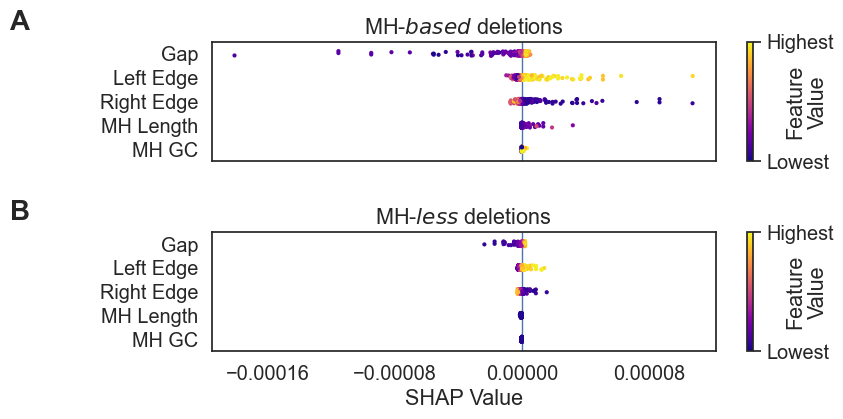

In [13]:
import string

samples_to_drop = ["Oligo_14023"]

swarm_df = swarm_df[swarm_df["Sample_Name"] != "Oligo_14023"]


abs_median_df = swarm_df.iloc[:,2:4]
abs_median_df["SHAP Value"] = abs_median_df["SHAP Value"].abs()
abs_median_df = abs_median_df.groupby("Feature").median().reset_index()
feature_order = list(abs_median_df.sort_values("SHAP Value", ascending=False)["Feature"])

sns.set(font_scale=1.3)
sns.set_style("white")

fig, ax = plt.subplots(2, 1, figsize=(9, 4.5), sharex=True, sharey=True)

swarm_df["log10(abs(SHAP Value))"] = np.log10(np.abs(swarm_df["SHAP Value"]))
swarm_df["log10(abs(SHAP Value))"] = swarm_df["log10(abs(SHAP Value))"] * np.where(swarm_df["SHAP Value"] > 0, -1, 1)

SV_to_plot = "SHAP Value"
ax1 = ax[0]
g = sns.stripplot(data=swarm_df[swarm_df["Del Type"] == "MH-Based"], \
    x=SV_to_plot , y="Feature", hue="Feature Value", \
        palette='plasma', s=3, order=feature_order, \
            ax=ax1)
g.legend().remove()


ax2 = ax[1]

g = sns.stripplot(data=swarm_df[swarm_df["Del Type"] == "MH-Less"], \
    x=SV_to_plot, y="Feature", hue="Feature Value", \
        palette='plasma', s=3, order=feature_order, \
            ax=ax2)
g.legend().remove()


norm = plt.Normalize(0, 1)
sm = plt.cm.ScalarMappable(cmap='plasma', norm=norm)
sm.set_array([])

SV_xlabel = r'$log_{10}(|SV|)$ ' + r'$\times$' + ' $sign(SV)^{-1}$' if "log10" in SV_to_plot else "SHAP Value"
SV_xlim =  (-10, 10) if "log10" in SV_to_plot else (-2.5e-4, 2.5e-4)


ax1.axvline(0.0, linewidth=1)
ax1.title.set_text('MH-$\it{based}$ deletions')
ax1.set_ylabel(None)
ax1.set_xlabel(None)
ax1.xaxis.set_major_locator(MaxNLocator(5)) 
cbar = fig.colorbar(sm, ax=ax1)
cbar.set_ticks([0.0, 1.0])
cbar.set_ticklabels(["Lowest", "Highest"])
cbar.ax.set_ylabel('Feature\nValue', labelpad=-35, rotation=90)


ax2.axvline(0.0, linewidth=1)
ax2.title.set_text('MH-$\it{less}$ deletions')
ax2.set_ylabel(None)
ax2.set_xlim(ax1.get_xlim())
ax2.set_xlabel(SV_xlabel)
ax2.xaxis.set_major_locator(MaxNLocator(5)) 
cbar = fig.colorbar(sm, ax=ax2)
cbar.set_ticks([0.0, 1.0])
cbar.set_ticklabels(["Lowest", "Highest"])
cbar.ax.set_ylabel('Feature\nValue', labelpad=-35, rotation=90)



for n, ax in enumerate([ax1, ax2]):
    ax.text(-0.4, 1.1, string.ascii_uppercase[n], transform=ax.transAxes, 
            size=20, weight='bold')

plt.tight_layout()
plt.savefig("./artifacts/shap_deletion_model.pdf", facecolor="white",  bbox_inches='tight')


In [14]:
ins_swarm_df["abs(SHAP Value)"] = np.abs(ins_swarm_df["SHAP Value"])
sorted_ins_features = ins_swarm_df.groupby(["Feature"])\
    .mean(numeric_only=True)\
    .sort_values(by="abs(SHAP Value)", ascending=False)\
    .index.to_list()
top_ins_features = sorted_ins_features[:30]
ins_swarm_df["Feature"] = pd.Categorical(ins_swarm_df["Feature"], categories=sorted_ins_features, ordered=True)
ins_swarm_df["Insertion"] = ins_swarm_df["Class"].str[-1]

In [15]:
ins_plot_df = ins_swarm_df[ins_swarm_df["Feature"].isin(top_ins_features)].sort_values(by=["Feature Value"], ascending=True)

In [16]:
indel_swarm_df["abs(SHAP Value)"] = np.abs(indel_swarm_df["SHAP Value"])
sorted_indel_features = indel_swarm_df.groupby(["Feature"])\
    .mean(numeric_only=True)\
    .sort_values(by="abs(SHAP Value)", ascending=False)\
    .index.to_list()
top_indel_features = sorted_indel_features[:30]
indel_swarm_df["Feature"] = pd.Categorical(indel_swarm_df["Feature"], categories=sorted_indel_features, ordered=True)

In [17]:
indel_plot_df = indel_swarm_df[indel_swarm_df["Feature"].isin(top_indel_features)].sort_values(by=["Feature Value"], ascending=True)

/var/folders/5x/n2td64g918lgvdh3qm2x3bhc0000gn/T/ipykernel_68427/1009368993.py:29: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax3.set_yticklabels(top_ins_features)
/var/folders/5x/n2td64g918lgvdh3qm2x3bhc0000gn/T/ipykernel_68427/1009368993.py:38: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax4.set_yticklabels(top_indel_features)


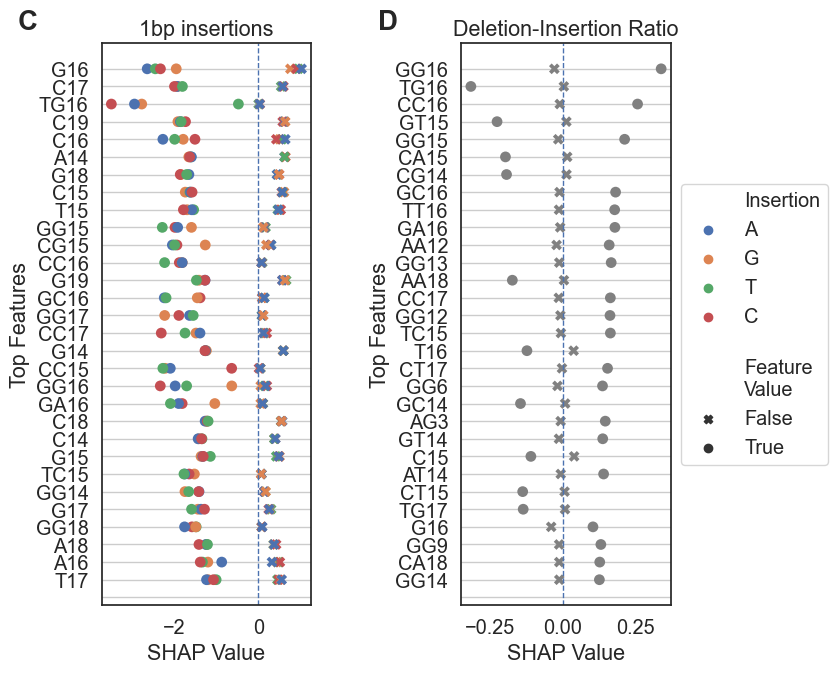

In [18]:
import string

sns.set(font_scale=1.3)
sns.set_style("white")

fig, ax = plt.subplots(1, 2, figsize=(9, 7), sharex=False, sharey=False)

ax3 = ax[0]
g = sns.scatterplot(data=ins_plot_df, \
    x="SHAP Value", y="Feature", hue="Insertion", style="Feature Value", s=60, palette="deep", markers=["X", "o"], ax=ax3, edgecolor="none")
ax3.grid(axis="y")


ax4 = ax[1]
# ax4.plot([], [], ' ', label="Feature\nValue")
g = sns.scatterplot(data=indel_plot_df, \
     y="Feature", x="SHAP Value", style="Feature Value", color="grey", ax=ax4, markers=["X", "o"], s=60, legend=False, edgecolor="none")
ax4.grid(axis="y")

legend_ax2 = ax4.legend(*ax3.get_legend_handles_labels(), loc='center left', bbox_to_anchor=(1, 0.5))
legend_ax2.get_texts()[-3].set_text('\nFeature\nValue')
legend_ax2.get_texts()[-2].set_text('False')
legend_ax2.get_texts()[-1].set_text('True')
ax3.legend().set_visible(False)


ax3.title.set_text('1bp insertions')
ax3.axvline(0.0, linestyle='--', linewidth=1)
ax3.set_yticklabels(top_ins_features)
ax3.set_ylabel("Top Features")
ax3.set_xlabel("SHAP Value")
# ax2_divider = make_axes_locatable(ax3)
# cax2 = ax2_divider.append_axes("right", size="25%", pad="2%")
# cax2.axis('off')


ax4.title.set_text('Deletion-Insertion Ratio')
ax4.set_yticklabels(top_indel_features)
ax4.axvline(0.0, linestyle='--', linewidth=1)
ax4.set_ylabel("Top Features")
ax4.set_xlabel("SHAP Value")
# ax3_divider = make_axes_locatable(ax4)
# cax3 = ax3_divider.append_axes("right", size="25%", pad="2%")
# cax3.axis('off')

for n, ax in enumerate([ax3, ax4]):
    ax.text(-0.4, 1.025, string.ascii_uppercase[n + 2], transform=ax.transAxes, 
            size=20, weight='bold')

plt.tight_layout()
plt.savefig("./artifacts/shap_insertion_indel_models.pdf", facecolor="white",  bbox_inches='tight')


In [19]:
import io
import fitz
from PIL import Image

file = '/Users/colm/repos/x-crisp/docs/Insertion indexing.pdf'
pdf_file = fitz.open(file)

# in case there is a need to loop through multiple PDF pages
for page_number in range(len(pdf_file)):
    page = pdf_file[page_number]
    rgb = page.get_pixmap(dpi=600)
    svg = page.get_svg_image()
    pil_image = Image.open(io.BytesIO(rgb.tobytes()))

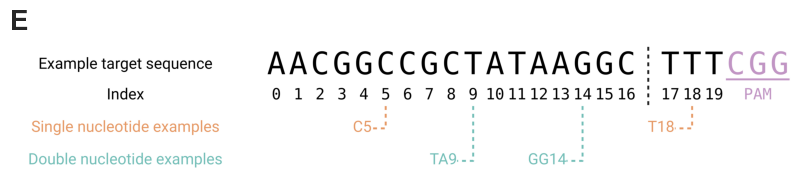

In [20]:
sns.set(font_scale=1.3)
sns.set_style("white")

fig, ax = plt.subplots(1, 1, figsize=(9, 2), sharex=False, sharey=False)
ax.set_axis_off()
ax.text(0, 1.1, "E", transform=ax.transAxes, 
            size=20, weight='bold')
plt.imshow(pil_image.convert('RGB'))
plt.tight_layout()
plt.savefig("./artifacts/indexing.pdf", facecolor="white",  bbox_inches='tight', dpi=600)


/var/folders/5x/n2td64g918lgvdh3qm2x3bhc0000gn/T/ipykernel_68427/2716377623.py:29: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax3.set_yticklabels(top_ins_features)
/var/folders/5x/n2td64g918lgvdh3qm2x3bhc0000gn/T/ipykernel_68427/2716377623.py:38: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax4.set_yticklabels(top_indel_features)


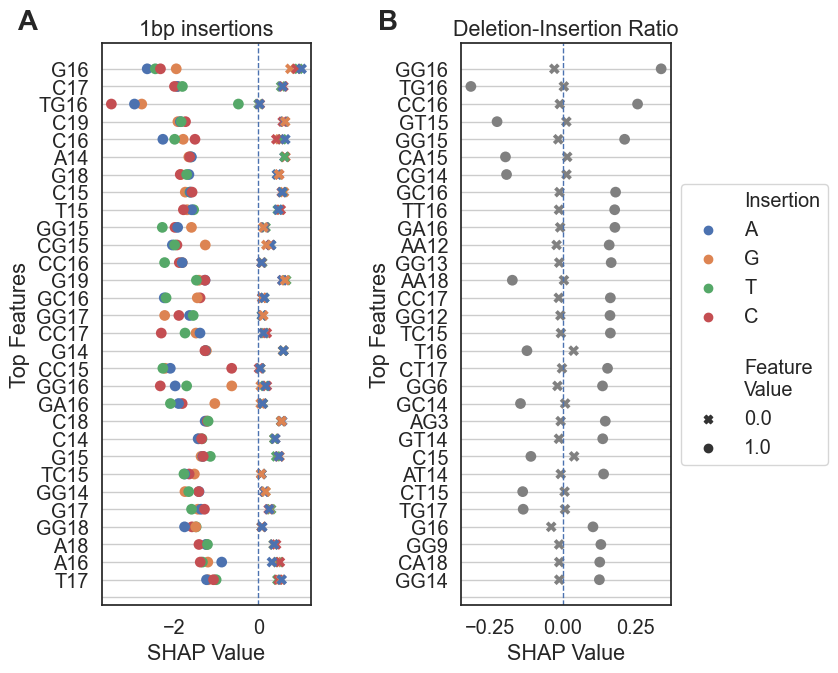

In [21]:
import string

sns.set(font_scale=1.3)
sns.set_style("white")

fig, ax = plt.subplots(1, 2, figsize=(9, 7), sharex=False, sharey=False)

ax3 = ax[0]
g = sns.scatterplot(data=ins_plot_df, \
    x="SHAP Value", y="Feature", hue="Insertion", style="Feature Value", s=60, palette="deep", markers=["X", "o"], ax=ax3, edgecolor="none")
ax3.grid(axis="y")


ax4 = ax[1]
# ax4.plot([], [], ' ', label="Feature\nValue")
g = sns.scatterplot(data=indel_plot_df, \
     y="Feature", x="SHAP Value", style="Feature Value", color="grey", ax=ax4, markers=["X", "o"], s=60, legend=False, edgecolor="none")
ax4.grid(axis="y")

legend_ax2 = ax4.legend(*ax3.get_legend_handles_labels(), loc='center left', bbox_to_anchor=(1, 0.5))
legend_ax2.get_texts()[-3].set_text('\nFeature\nValue')
# legend_ax2.get_texts()[-2].set_text('False')
# legend_ax2.get_texts()[-1].set_text('True')
ax3.legend().set_visible(False)


ax3.title.set_text('1bp insertions')
ax3.axvline(0.0, linestyle='--', linewidth=1)
ax3.set_yticklabels(top_ins_features)
ax3.set_ylabel("Top Features")
ax3.set_xlabel("SHAP Value")
# ax2_divider = make_axes_locatable(ax3)
# cax2 = ax2_divider.append_axes("right", size="25%", pad="2%")
# cax2.axis('off')


ax4.title.set_text('Deletion-Insertion Ratio')
ax4.set_yticklabels(top_indel_features)
ax4.axvline(0.0, linestyle='--', linewidth=1)
ax4.set_ylabel("Top Features")
ax4.set_xlabel("SHAP Value")
# ax3_divider = make_axes_locatable(ax4)
# cax3 = ax3_divider.append_axes("right", size="25%", pad="2%")
# cax3.axis('off')

for n, ax in enumerate([ax3, ax4]):
    ax.text(-0.4, 1.025, string.ascii_uppercase[n], transform=ax.transAxes, 
            size=20, weight='bold')

plt.tight_layout()
plt.savefig("./artifacts/shap_insertion_indel_models_thesis.pdf", facecolor="white",  bbox_inches='tight')


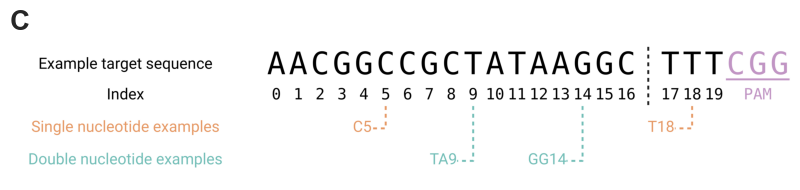

In [22]:
sns.set(font_scale=1.3)
sns.set_style("white")

fig, ax = plt.subplots(1, 1, figsize=(9, 2), sharex=False, sharey=False)
ax.set_axis_off()
ax.text(0, 1.1, "C", transform=ax.transAxes, 
            size=20, weight='bold')
plt.imshow(pil_image.convert('RGB'))
plt.tight_layout()
plt.savefig("./artifacts/indexing_thesis.pdf", facecolor="white",  bbox_inches='tight', dpi=600)